<a href="https://colab.research.google.com/github/yuvalira/Final-Project-Adversarial-Attack-on-Tabular-Classification/blob/main/ATTACK/GBT_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import os
import pandas as pd
import joblib
from scipy.stats import pointbiserialr
import numpy as np
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
import pickle
import matplotlib.pyplot as plt

# **Adversarial Attack**

### 1. Get Model and Data from Git

In [8]:
# Git clone
REPO_URL = "https://github.com/yuvalira/Final-Project-Adversarial-Attack-on-Tabular-Classification.git"
!git clone {REPO_URL}
%cd Final-Project-Adversarial-Attack-on-Tabular-Classification

# Read test dataset
test_data = pd.read_csv('data/test_data.csv')
print(f"test_data loaded: {test_data.shape}")

# Read GBT model (sklearn)
model_path = 'GBT/sklearn_GBT_model.joblib'
assert os.path.exists(model_path), f"Model file not found at {model_path}"

model_gbt = joblib.load(model_path)
print("sklearn GBT model loaded successfully.")

# Load label encoders for decoding categorical features
with open('data/label_encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)
print("Label encoders loaded successfully.")

Cloning into 'Final-Project-Adversarial-Attack-on-Tabular-Classification'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 155 (delta 62), reused 74 (delta 28), pack-reused 0 (from 0)
Receiving objects: 100% (155/155), 2.94 MiB | 10.02 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/Final-Project-Adversarial-Attack-on-Tabular-Classification/Final-Project-Adversarial-Attack-on-Tabular-Classification/Final-Project-Adversarial-Attack-on-Tabular-Classification
test_data loaded: (9769, 15)
sklearn GBT model loaded successfully.
Label encoders loaded successfully.


### 2. Prepare Data-Frames

Create Correct Predictions and Incorrect Predictions datasets

In [9]:
TARGET_COLUMN_NAME = 'income'

# Create a copy of test_data
test_data_attack = test_data.copy()

# Prepare test features
exclude_columns = [TARGET_COLUMN_NAME, 'fnlwgt']
X_test = test_data.drop(columns=exclude_columns)
y_true = test_data[TARGET_COLUMN_NAME].values

# Predict class labels (0/1)
y_pred = model_gbt.predict(X_test)

# Create a new column for prediction correctness
test_data_attack['correct_prediction'] = (y_true == y_pred)

# Create datasets for correct and incorrect predictions
correct_predictions_df = test_data_attack[test_data_attack['correct_prediction'] == True].drop(columns=['correct_prediction'])
incorrect_predictions_df = test_data_attack[test_data_attack['correct_prediction'] == False].drop(columns=['correct_prediction'])

print(f"Correct predictions shape : {correct_predictions_df.shape}")
print(f"Incorrect predictions shape : {incorrect_predictions_df.shape}")


Correct predictions shape : (8572, 15)
Incorrect predictions shape : (1197, 15)


### 3. Create Correlation Dictionary

We compute a correlation dictionary to guide and constrain the adversarial attack process.  
For each feature and possible value, we calculate the correlation between the presence of that value and the target label.

The correlation dictionary serves three key purposes:
1. **Feature Filtering:** Only features with correlation above a defined threshold are considered for attack.
2. **Feature Prioritization:** Features are sorted by correlation strength to guide the attack toward the most influential attributes first.
3. **Categorical Attack Control:** For categorical features, value changes are limited to neighboring values based on their position in the correlation dictionary, avoiding random or unrealistic jumps between categories.

In [10]:
def create_correlation_dict(df, target_column='income'):
    """
    Create a dictionary of correlation values between feature values and the target class.
    Used for driving adversarial attack modifications.
    """
    correlation_dict = {}
    target = df[target_column]
    features = df.drop(columns=[target_column, 'fnlwgt'])

    for col in features.columns:
        value_corrs = {}

        # Categorical or numerical feature
        if features[col].dtype == 'object' or features[col].dtype.name == 'category':
            unique_vals = features[col].unique()
        else:
            unique_vals = np.unique(features[col].values)

        for val in unique_vals:
            binary_vec = features[col].apply(lambda x: 1 if x == val else 0)
            try:
                corr, _ = pointbiserialr(binary_vec, target)
            except Exception:
                corr = 0

            # Clean numpy types
            if isinstance(val, (np.integer, np.int64)):
                val = int(val)

            value_corrs[val] = corr if not np.isnan(corr) else 0

        # Sort values by correlation descending
        correlation_dict[col] = dict(sorted(value_corrs.items(), key=lambda x: x[1], reverse=True))

    return correlation_dict

In [11]:
correlation_dict = create_correlation_dict(correct_predictions_df, target_column="income")

# Print correlation dict
for feature, val_corrs in correlation_dict.items():
    print(f"\nFeature: {feature}")
    for val, corr in val_corrs.items():
        # If feature is categorical and encoder exists → decode value
        if feature in encoders:
            val = encoders[feature].inverse_transform([int(val)])[0]
        print(f"    {val}: {corr:.4f}")


Feature: age
    46: 0.0828
    47: 0.0791
    45: 0.0771
    42: 0.0736
    50: 0.0650
    51: 0.0602
    48: 0.0591
    44: 0.0572
    38: 0.0552
    52: 0.0537
    43: 0.0480
    41: 0.0478
    39: 0.0395
    53: 0.0371
    49: 0.0353
    40: 0.0349
    37: 0.0331
    54: 0.0311
    58: 0.0310
    57: 0.0280
    55: 0.0255
    83: 0.0229
    60: 0.0168
    36: 0.0166
    59: 0.0157
    79: 0.0154
    56: 0.0150
    61: 0.0140
    32: 0.0091
    62: 0.0084
    73: 0.0020
    63: 0.0018
    78: 0.0012
    80: 0.0012
    65: -0.0003
    34: -0.0020
    70: -0.0020
    69: -0.0029
    71: -0.0030
    67: -0.0041
    81: -0.0045
    64: -0.0051
    88: -0.0051
    84: -0.0072
    76: -0.0072
    90: -0.0084
    66: -0.0093
    82: -0.0102
    35: -0.0126
    68: -0.0139
    75: -0.0161
    77: -0.0161
    74: -0.0176
    72: -0.0216
    33: -0.0258
    30: -0.0264
    31: -0.0297
    29: -0.0409
    17: -0.0534
    28: -0.0537
    27: -0.0647
    24: -0.0656
    18: -0.0666
    25: -0.0

### 4. Adversarial Attack Generation

This function generates adversarial examples by applying controlled perturbations to the input samples.  
The attack follows a structured approach to efficiently search for minimal changes that will flip the model's prediction:

1. **Input Selection:** Only correctly predicted samples are selected for the attack.
2. **Feature Selection:** Features are prioritized and filtered based on the correlation dictionary.
3. **Attack Loop:** For each sample:
   - For **numeric features**, the value is perturbed by adding or subtracting a small pre-defined delta.
   - For **categorical features**, the current value is replaced by neighboring values in the correlation dictionary (not random replacements).
   - After each change, the model is queried. If the prediction flips, the attack stops for that sample.

This method ensures that the attack remains realistic and focused on high-impact feature manipulations, avoiding excessive or implausible modifications.

In [12]:
def generate_adversarial_attack(
        df_test, model_gbt, correlation_dict,
        max_features_changed=3,
        correlation_threshold=0.05, max_attempts=10):

    # Declare bounds for numeric features
    numeric_bounded_features = {
        'age': 5,
        'hours-per-week': 5,
        'capital-gain': 1000,
        'capital-loss': 1000,
        'educational-num' : 2,
    }

    adv_samples = []
    success_count = 0
    df_types = df_test.dtypes.to_dict()

    # Prepare test set
    exclude_columns = [TARGET_COLUMN_NAME, 'fnlwgt']
    X_test = df_test.drop(columns=exclude_columns)
    y_true = df_test[TARGET_COLUMN_NAME].values
    y_pred_orig = model_gbt.predict(X_test)

    # Prioritize features by correlation
    priorities = []
    for feature in correlation_dict.keys():
        if feature == TARGET_COLUMN_NAME or feature not in df_test.columns:
            continue
        values = correlation_dict[feature].values()
        max_corr = max(abs(v) for v in values if v is not None)
        if max_corr >= correlation_threshold:
            priorities.append((feature, max_corr))

    priorities.sort(key=lambda x: x[1], reverse=True)
    ordered_features = [f[0] for f in priorities]

    for idx in range(len(df_test)):
        original_input = df_test.iloc[[idx]]
        original_label = original_input[TARGET_COLUMN_NAME].values[0]
        current_sample = original_input.iloc[0].copy()
        changed_features = set()
        success = False
        attempts = 0

        while len(changed_features) < max_features_changed and attempts < max_attempts:
            attempts += 1
            current_X = pd.DataFrame([current_sample.drop(labels=[TARGET_COLUMN_NAME, 'fnlwgt'])])
            current_pred = model_gbt.predict(current_X)[0]

            if current_pred != original_label:
                success = True
                break

            candidate_samples = []
            candidate_features = []

            for feature in ordered_features:
                if feature in changed_features:
                    continue

                current_value = current_sample[feature]

                # Numeric feature
                if feature in numeric_bounded_features:
                    delta = numeric_bounded_features[feature]
                    try:
                        current_value = float(current_value)
                        for new_val in [current_value + delta, max(0, current_value - delta)]:
                            trial_sample = current_sample.copy()
                            trial_sample[feature] = new_val
                            candidate_samples.append(trial_sample)
                            candidate_features.append(feature)
                    except:
                        continue

                # Categorical feature
                else:
                    possible_vals = list(correlation_dict[feature].keys())
                    current_value_int = int(current_value) if isinstance(current_value, (np.integer, np.int64)) else current_value
                    try:
                        idx_val = possible_vals.index(current_value_int)
                    except ValueError:
                        continue

                    neighbors = []
                    if idx_val - 2 >= 0:
                        neighbors.append(possible_vals[idx_val - 2])
                    if idx_val + 2 < len(possible_vals):
                        neighbors.append(possible_vals[idx_val + 2])
                    if not neighbors and len(possible_vals) > 1:
                        if idx_val > 0:
                            neighbors.append(possible_vals[idx_val - 1])
                        if idx_val < len(possible_vals) - 1:
                            neighbors.append(possible_vals[idx_val + 1])

                    for neighbor_val in neighbors:
                        trial_sample = current_sample.copy()
                        trial_sample[feature] = neighbor_val
                        candidate_samples.append(trial_sample)
                        candidate_features.append(feature)

                if len(candidate_samples) >= 20:
                    break

            if not candidate_samples:
                break

            batch_X = pd.DataFrame(candidate_samples)[[col for col in current_sample.index if col not in [TARGET_COLUMN_NAME, 'fnlwgt']]]
            batch_preds = model_gbt.predict(batch_X)

            for i, pred in enumerate(batch_preds):
                if int(pred) != original_label:
                    current_sample = candidate_samples[i]
                    changed_features.add(candidate_features[i])
                    break

        adv_samples.append(current_sample.astype(object))
        if success:
            success_count += 1

    adv_df = pd.DataFrame(adv_samples).astype(df_types)

    # Evaluation
    adv_X = adv_df.drop(columns=[TARGET_COLUMN_NAME, 'fnlwgt'])
    y_pred_adv = model_gbt.predict(adv_X)

    flipped = sum(y_pred_orig != y_pred_adv)
    print(f"\n Attack success: {success_count}/{len(df_test)} ({(success_count/len(df_test))*100:.2f}%)")
    print(f" Original accuracy: {accuracy_score(y_true, y_pred_orig):.2%}")
    print(f" Adversarial accuracy: {accuracy_score(y_true, y_pred_adv):.2%}")

    return adv_df

Now, we apply the adversarial attack on the set of correctly predicted test samples from the Gradient Boosted Trees (GBT) model.  

This step generates the adversarial dataset (`adv_test_df`) used for further evaluation and analysis.


In [13]:
# Select subset of samples to attack
samples_to_attack = correct_predictions_df.copy()

# Run adversarial attack
adv_test_df = generate_adversarial_attack(
    df_test=samples_to_attack,
    model_gbt=model_gbt,
    correlation_dict=correlation_dict
)

print(f"\n Attack finished. Adversarial test set shape: {adv_test_df.shape}")


 Attack success: 1718/8572 (20.04%)
 Original accuracy: 100.00%
 Adversarial accuracy: 79.96%

 Attack finished. Adversarial test set shape: (8572, 15)


### 5. Attack Evaluation

In [26]:
def analyze_attack_changes(original_df, adversarial_df, label_column='income', verbose=True, max_samples_to_print=10):
    """
    Analyze feature changes between original and adversarial samples.
    Returns: list of differences per sample, and feature change counts.
    Only prints up to max_samples_to_print changed samples for readability.
    """
    feature_names = [f for f in original_df.columns if f not in [label_column, 'fnlwgt']]
    change_counts = {feature: 0 for feature in feature_names}
    total_samples = len(original_df)

    all_diffs = []
    printed_samples = 0

    for idx in range(total_samples):
        orig_row = original_df.iloc[idx]
        adv_row = adversarial_df.iloc[idx]
        diffs = {}
        for feature in feature_names:
            if orig_row[feature] != adv_row[feature]:
                old_val = orig_row[feature]
                new_val = adv_row[feature]

                # decode categorical values back to original labels
                if feature in encoders:
                    try:
                        old_val = encoders[feature].inverse_transform([int(old_val)])[0]
                        new_val = encoders[feature].inverse_transform([int(new_val)])[0]
                    except Exception:
                        pass  # in case of any weird value, just keep as is

                diffs[feature] = (old_val, new_val)
                change_counts[feature] += 1

        all_diffs.append(diffs)

        if verbose and diffs and printed_samples < max_samples_to_print:
            print(f"\nSample {idx}: {len(diffs)} feature(s) changed:")
            for feat, (old, new) in diffs.items():
                print(f"  {feat}: {old} → {new}")
            printed_samples += 1

    # Summary
    print("\n--- Global Feature Change Statistics ---")
    for feature, count in change_counts.items():
        print(f"{feature}: changed in {count}/{total_samples} samples ({(count/total_samples)*100:.2f}%)")

    print("\n Attack analysis completed.")
    return all_diffs, change_counts

In [27]:
all_diffs, change_counts = analyze_attack_changes(
    original_df=samples_to_attack,
    adversarial_df=adv_test_df,
    label_column='income'
)


Sample 6: 1 feature(s) changed:
  relationship: Wife → Unmarried

Sample 12: 1 feature(s) changed:
  relationship: Other-relative → Husband

Sample 13: 1 feature(s) changed:
  educational-num: 11 → 13

Sample 17: 1 feature(s) changed:
  capital-loss: 1408 → 2408

Sample 18: 1 feature(s) changed:
  capital-loss: 3004 → 2004

Sample 24: 1 feature(s) changed:
  age: 24 → 29

Sample 26: 1 feature(s) changed:
  relationship: Wife → Unmarried

Sample 27: 1 feature(s) changed:
  relationship: Husband → Other-relative

Sample 38: 1 feature(s) changed:
  educational-num: 9 → 11

Sample 43: 1 feature(s) changed:
  relationship: Unmarried → Wife

--- Global Feature Change Statistics ---
age: changed in 34/8572 samples (0.40%)
workclass: changed in 24/8572 samples (0.28%)
education: changed in 24/8572 samples (0.28%)
educational-num: changed in 244/8572 samples (2.85%)
marital-status: changed in 139/8572 samples (1.62%)
occupation: changed in 93/8572 samples (1.08%)
relationship: changed in 833/8

**Model Robustness Comparison**

Now, we will evaluate the model on both the original test set and the full attacked test set.  


In [24]:
# Predict on original test set (before attack)
X_original = test_data.drop(columns=['income', 'fnlwgt'])
y_original = test_data['income']

y_pred_original = model_gbt.predict(X_original)

# Combine attacked + incorrect samples to create full attacked dataset
full_attacked_test_data = pd.concat([adv_test_df, incorrect_predictions_df], axis=0).reset_index(drop=True)

X_attacked = full_attacked_test_data.drop(columns=['income', 'fnlwgt'])
y_attacked = full_attacked_test_data['income']

y_pred_attacked = model_gbt.predict(X_attacked)

# Calculate metrics for original test set
original_accuracy = accuracy_score(y_original, y_pred_original)
original_precision = precision_score(y_original, y_pred_original)
original_recall = recall_score(y_original, y_pred_original)
original_f1 = f1_score(y_original, y_pred_original)

# Calculate metrics for attacked test set
attacked_accuracy = accuracy_score(y_attacked, y_pred_attacked)
attacked_precision = precision_score(y_attacked, y_pred_attacked)
attacked_recall = recall_score(y_attacked, y_pred_attacked)
attacked_f1 = f1_score(y_attacked, y_pred_attacked)

# Print comparison
print("\n Model Performance Comparison:")
print(f" Original Accuracy: {original_accuracy:.4f} | Attacked Accuracy: {attacked_accuracy:.4f}")
print(f" Original Precision: {original_precision:.4f} | Attacked Precision: {attacked_precision:.4f}")
print(f" Original Recall: {original_recall:.4f} | Attacked Recall: {attacked_recall:.4f}")
print(f" Original F1-Score: {original_f1:.4f} | Attacked F1-Score: {attacked_f1:.4f}")

# Accuracy drop
drop = original_accuracy - attacked_accuracy
print(f"\n Accuracy drop due to attack: {drop:.4f} ({drop*100:.2f}% drop)")



 Model Performance Comparison:
 Original Accuracy: 0.8775 | Attacked Accuracy: 0.7016
 Original Precision: 0.7709 | Attacked Precision: 0.3395
 Original Recall: 0.6790 | Attacked Recall: 0.2886
 Original F1-Score: 0.7221 | Attacked F1-Score: 0.3120

 Accuracy drop due to attack: 0.1759 (17.59% drop)


**ROC Curve Comparison Before and After Attack**

We compare the Receiver Operating Characteristic (ROC) curves of the model on the original test set and after the adversarial attack.  
A lower ROC curve and AUC after attack indicates degradation of the model's classification ability.

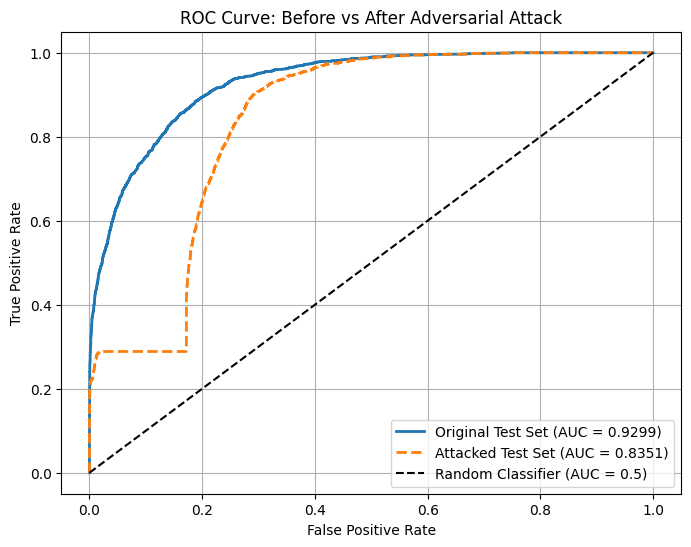

In [22]:
# Original test set
X_original = test_data.drop(columns=['income', 'fnlwgt'])
y_original = test_data['income']
y_score_original = model_gbt.predict_proba(X_original)[:, 1]
auc_original = roc_auc_score(y_original, y_score_original)
fpr_original, tpr_original, _ = roc_curve(y_original, y_score_original)

# Attacked test set
X_attacked = full_attacked_test_data.drop(columns=['income', 'fnlwgt'])
y_attacked = full_attacked_test_data['income']
y_score_attacked = model_gbt.predict_proba(X_attacked)[:, 1]
auc_attacked = roc_auc_score(y_attacked, y_score_attacked)
fpr_attacked, tpr_attacked, _ = roc_curve(y_attacked, y_score_attacked)

# Plot both curves
plt.figure(figsize=(8,6))
plt.plot(fpr_original, tpr_original, label=f"Original Test Set (AUC = {auc_original:.4f})", linewidth=2)
plt.plot(fpr_attacked, tpr_attacked, label=f"Attacked Test Set (AUC = {auc_attacked:.4f})", linewidth=2, linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Before vs After Adversarial Attack")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


The ROC curve comparison shows a significant reduction in model performance under adversarial attack.  
The AUC dropped from 0.9299 to 0.8351, demonstrating that the structured attack succeeded in reducing the model's ability to distinguish between income classes.